# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
os.chdir("../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [ ]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics

In [ ]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=1,
          tokenizer_version=1,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=7,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          print_freq=6,
          random_seed=20,
          scheduler='cosine',
          stride=192,
          train=True,
          train_folds=[0, 1, 2, 3, 4],
          weight_decay=0.01)


In [ ]:
seed_everything()

### Setting Up WandB

In [ ]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
WANDB_NAME = f"{config.model}-{config.max_length}"

In [ ]:
wandb.login(key=os.environ.get('WANDB_NOTEBOOK_NAME'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin


## 📖 Definitions

### 🌎 Global Variables

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 🛠️ Functions

In [ ]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(train_loader, device)

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    # class_weights = torch.tensor([0.928, 0.773, 0.637, 0.727, 0.944, 1.0]).to(device)
    # class_weights = torch.tensor([1.0, 0.75, 0.5, 0.75, 1.0, 1.5]).to(device)
    class_weights = torch.tensor([1.0] * 6).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, predictions = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)

        wandb.log(
            {
                f"eval/eval_loss_f{fold}": avg_val_loss,
                f"eval/epoch_f{fold}": epoch,
                f"eval/qwk_score_f{fold}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                Paths.MODEL_OUTPUT_PATH
                + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    valid_fold["pred_score"] = predictions

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [ ]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [ ]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Train:  32%|███▏      | 143/445 [00:47<01:39,  3.03train_batch/s]


KeyboardInterrupt: 

In [ ]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [ ]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

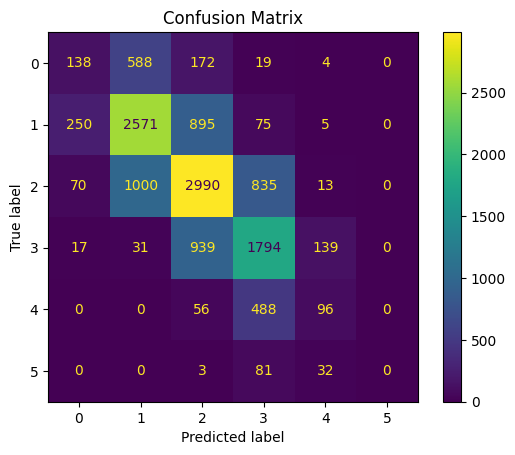

In [ ]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [ ]:
wandb.finish()

CV/Accuracy,▆▃▁▃▇█
CV/Error Rate,▃▆█▆▂▁
CV/F1 Score,▁█▇▇▁
CV/Precision,▁██▇▂
CV/Recall,▃█▇▇▃▁
CV/Sensitivity,▃█▇▇▃▁
CV/Specificity,▇▃▁▄██
CV/qwk_score,▁
CV/score,▁▂▄▅▇█
eval/epoch_f0,▁█
eval/epoch_f1,▁█
